In [8]:
import os 
import time
import copy
import math 

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

from torchviz import make_dot

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import random 
import pandas as pd

using device cuda:0


In [9]:
def cuda(input):
    if torch.cuda.is_available(): return input.cuda()
    return input

def onehencodechar(char, encoder):
    x = torch.zeros(len(encoder),1)
    x[encoder[char]] = 1.0
    return cuda(x.t())

def onehencodestr(string, encoder):
    x = torch.zeros((len(string),len(encoder)))
    x[[idx for idx in range(0,len(string))],[encoder[char] for char in string]] = 1
    return cuda(x)

def encodeYstr(string, encoder):
    return cuda(torch.Tensor([encoder[char] for char in string]))

def encodechar(char, encoder):
    return cuda(torch.tensor(encoder[target_str[i]]).unsqueeze(0))

In [10]:
class RNN(nn.Module):
    def __init__(self, in_sz, hd_sz, out_sz):
        super(RNN,self).__init__()
        self.in_sz  = in_sz
        self.hd_sz  = hd_sz
        self.out_sz = out_sz        
        
        self.h1 = nn.Linear(self.in_sz + self.hd_sz, self.hd_sz)
        self.o1 = nn.Linear(self.in_sz + self.hd_sz, self.in_sz)

    def forward(self, input, hidden):
        combined = torch.cat((input,hidden),1)
        print(combined.shape)
        hidden   = torch.tanh(self.h1(combined))
        output   = self.o1(combined)
        output2   = torch.softmax(output,1)
        print(self.h1.weight.shape)
        return output2, hidden
    
    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))
    

In [11]:
input_str  = 'abcde'
target_str = 'bcdef'

In [12]:
symbols = list(set(input_str + target_str))
encoder = {symb: idx for idx,symb in enumerate(symbols)}
decoder = {idx: symb for idx,symb in enumerate(symbols)}

In [13]:
hd_sz  = 10
in_sz  = len(decoder)
out_sz = 3

In [16]:
rnn = cuda(RNN(in_sz, hd_sz, out_sz))
criterion = nn.NLLLoss()
hidden = rnn.initHidden(1)
loss = 0 
for i in range(3):
    input = onehencodechar(input_str[i],encoder)
    print(input.shape,hidden.shape)
    output,hidden = rnn.forward(input,hidden)
    print(output.shape)    
    tmp_loss = criterion(output,encodechar(target_str[i],encoder))
    tmp_loss

    loss += tmp_loss

torch.Size([1, 6]) torch.Size([1, 10])
torch.Size([1, 16])
torch.Size([10, 16])
torch.Size([1, 6])
torch.Size([1, 6]) torch.Size([1, 10])
torch.Size([1, 16])
torch.Size([10, 16])
torch.Size([1, 6])
torch.Size([1, 6]) torch.Size([1, 10])
torch.Size([1, 16])
torch.Size([10, 16])
torch.Size([1, 6])


In [17]:
print(rnn)

RNN(
  (h1): Linear(in_features=16, out_features=10, bias=True)
  (o1): Linear(in_features=16, out_features=6, bias=True)
)


## notice that information is not lost when summing multiple losses

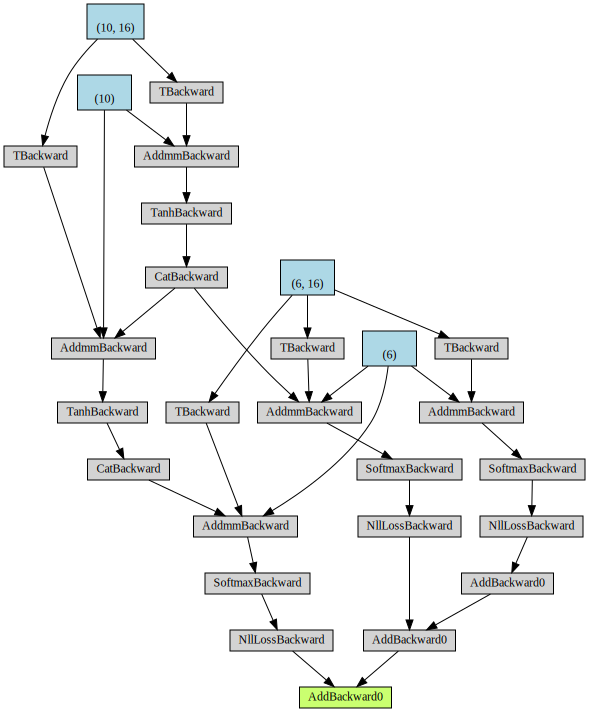

In [19]:
make_dot(loss)

## compare slicing input mid-training: 
### notice that the execution-graph remembers that the variables become sliced

In [23]:
i = 2

2

In [49]:
X = cuda(torch.zeros(2,3,len(decoder)))
Y = cuda(torch.zeros(2,3)).long()

In [50]:
x1 = X[:,i,:]
x21 = X[0,i,:]
x22 = X[:,i,:]

y1 = Y[:,i]
y21 = Y[0,i]
y22 = Y[:,i]

In [51]:
hidden = rnn.initHidden(2)

input = x1
output,hidden = rnn.forward(input,hidden)
loss = criterion(output,y1)

hidden = hidden[0,:].unsqueeze(0)
input = x21.unsqueeze(0)
output,hidden = rnn.forward(input,hidden)
y21 = y21.unsqueeze(0)
loss = criterion(output,y21)

torch.Size([2, 16])
torch.Size([10, 16])
torch.Size([1, 16])
torch.Size([10, 16])


## removing half input after one-pass through the RNN

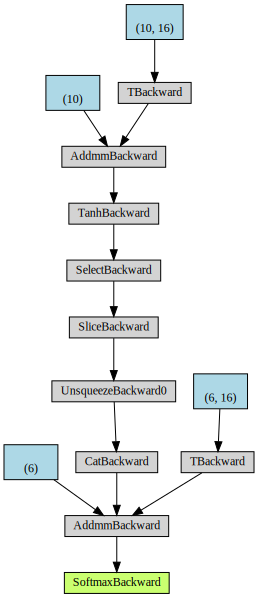

In [52]:
make_dot(output)

In [53]:
hidden = rnn.initHidden(2)
input = x1
output,hidden = rnn.forward(input,hidden)
loss = criterion(output,y1)
input = x22
output,hidden = rnn.forward(input,hidden)
loss = criterion(output,y22)


torch.Size([2, 16])
torch.Size([10, 16])
torch.Size([2, 16])
torch.Size([10, 16])


## no slicing

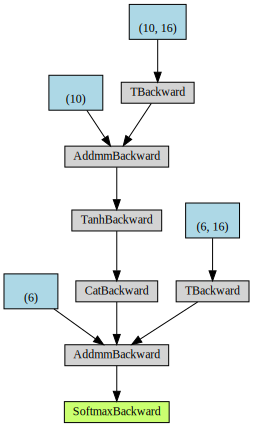

In [54]:
make_dot(output)